In [ ]:
# For mounting drive

from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# Reading cleaned dataset

import pandas as pd
path = '/content/drive/My Drive/BE PROJECT/Lawgical Final/LabelledDataset/'
df = pd.read_csv(path+'cleaned_dataset_new.csv')

In [ ]:
import pandas as pd
path = '/content/drive/My Drive/BE PROJECT/Lawgical Final/LabelledDataset/'
traindf = pd.read_csv(path+'train.csv')
testdf = pd.read_csv(path+'test.csv')
X_train = traindf.loc[:,'Judgement'].values
y_train = traindf.loc[:,'label'].values
X_test = testdf.loc[:,'Judgement'].values
y_test = testdf.loc[:,'label'].values

In [ ]:
# Reading Input Case

casename=testdf['Case Name'][6]
print(casename,'\n')
labelled = pd.read_csv(path+'Labelled_Dataset.csv')
filename = labelled.loc[labelled['Case Name'] == casename]['Filename'].values[0]
# print(filename)
label = labelled.loc[labelled['Case Name'] == casename]['label'].values[0]
# print(label)
if label == 'yes':
  filename = path+'dataset_positive/'+filename
elif label == 'no':
  filename = path+'dataset_negative/'+filename

f1 = open(filename, "r", encoding="utf8", errors='ignore')
text1 = f1.read()
print(text1)

Sathish @ Pakeera And Others V. State Of Karnataka 

1. The petitioners are Accused Nos.1, 2, 3 and 4 in Respondent-Basaralu Police Station in Crime No.3/2019 for the offence punishable under Section 395 of Indian Penal Code, 1860.

2. The summary of the allegations made against the accused in the FIR is that on the late night of 10.01.2019 i.e., at about 0030 hours on 11.01.2019, the accused who were five in number restrained the complainant on a public road and showing him a knife, threatening him with dire consequences, robbed cash of Rs.12,000, Bank ATM card and cell phone.

3. Learned counsel for the petitioners, in his arguments, submitted that the accused have been falsely implicated. The Police have implicated the accused in several similar cases falsely and only to fulfill their statistical purposes. As such, even though accused have been totally innocent, still the Police having no evidence, have falsely implicated them in several cases. He further submits that investigation 

In [ ]:
# Cleaned Text 
print(X_test[6])

1 petitioner accused nos1 2 3 4 crime no3/ offence punishable section 395 indian penal code 2 summary allegation make accuse late night 1001 ie 0030 hour accuse five number restrain complainant public road show knife threaten dire consequence rob cash card cell phone 3 learned counsel petitioner argument submit accuse falsely implicate police implicate accuse several similar case falsely fulfill statistical purpose even though accuse totally innocent still police evidence falsely implicate several case submit investigation complete charge sheet file continuation accuse judicial custody unnecessary 4 per contra learn special public prosecutor argument submit accuse include present petitioner habitual offender involve similar activity earlier also apprehend case enlarge bail also possibility repeat similar offence 5 reading complaint stage prima facie would go show prior incident complainant consume vodka beer along accuse say wait public road nano car thereafter proceed destination resp

In [ ]:
# Original Prediction
print(y_test[6])

1


## **BOW**

In [ ]:
# Vectorizinf the corpus using TFIDF Vectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
cv= CountVectorizer(ngram_range=(1,3), max_features=5000)
X_train_counts= cv.fit_transform(X_train)
tfidf_transformer = TfidfTransformer(use_idf=False)
train_vectors = tfidf_transformer.fit_transform(X_train_counts)
X_test_counts= cv.transform(X_test)
test_vectors = tfidf_transformer.transform(X_test_counts)
print(train_vectors.shape, test_vectors.shape)

(1596, 5000) (108, 5000)


In [ ]:
def top_tfidf_feats(row, features, top_n=20):
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

def top_mean_feats(X, features, grp_ids=None, min_tfidf=0.1, top_n=10):
    if grp_ids:
        D = X[grp_ids].toarray()
    else:
        D = X.toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

def top_feats_by_class(X, y, features, min_tfidf=0.1, top_n=20):
    dfs = []
    labels = np.unique(y)
    for label in labels:
        ids = np.where(y==label)
        feats_df = top_mean_feats(X, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs

def plot_tfidf_classfeats_h(dfs):
    fig = plt.figure(figsize=(15, 9), facecolor="w")
    x = np.arange(len(dfs[0]))
    for i, df in enumerate(dfs):
        ax = fig.add_subplot(1, len(dfs), i+1)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_frame_on(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_xlabel("Count Vectorizer score", labelpad=16, fontsize=14)
        ax.set_ylabel("Word", labelpad=16, fontsize=14)
        ax.set_title("Class = " + str(df.label), fontsize=16)
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
        ax.barh(x, df.tfidf, align='center')
        ax.set_yticks(x)
        ax.set_ylim([-1, x[-1]+1])
        yticks = ax.set_yticklabels(df.feature)
        plt.subplots_adjust(bottom=0.09, right=0.97, left=0.15, top=0.95, wspace=0.52)
    plt.show()

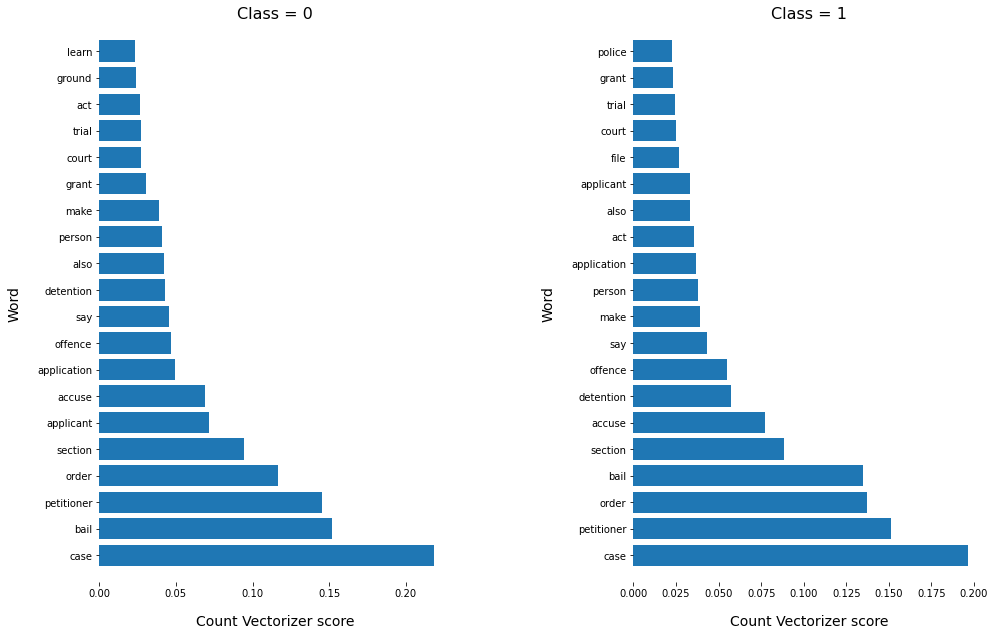

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
class_features = cv.get_feature_names()
class_top_dfs = top_feats_by_class(train_vectors, y_train, class_features)
plot_tfidf_classfeats_h(class_top_dfs)


In [ ]:
import numpy as np
tokens_and_counts = zip(cv.get_feature_names(), np.asarray(X_train_counts.sum(axis=0)).ravel())
dataframe=pd.DataFrame(tokens_and_counts, columns=['tokens', 'count'])
print(dataframe.sort_values('count').tail(10))

          tokens  count
3127     offence  14579
503         also  15312
4134         say  15643
2820        make  16346
335       accuse  16937
4188     section  23950
3435  petitioner  26579
788         bail  28467
3211       order  33227
961         case  41075


In [ ]:
! pip install -q scikit-plot

In [ ]:
from  sklearn.metrics  import accuracy_score
from  sklearn.metrics  import recall_score
from  sklearn.metrics  import precision_score
from sklearn.metrics import confusion_matrix
import scikitplot as skplt

In [ ]:
#scaling inputvectors using maxabsscaler
from sklearn import preprocessing
max_abs_scaler = preprocessing.MaxAbsScaler()
X_train_mabs= max_abs_scaler.fit_transform(train_vectors)
X_test_mabs= max_abs_scaler.transform(test_vectors)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rfclf=RandomForestClassifier(random_state= 4, bootstrap=False, n_estimators=1000)
rfclf.fit(X_train_mabs, y_train)

predicted=rfclf.predict(X_test_mabs)
print('Random Forest')
print('Accuracy Score = ',accuracy_score(y_test,predicted))
print('Recall Score = ',recall_score(y_test,predicted))
print('Precision Score = ',precision_score(y_test,predicted))
print('predicted output of example: ',rfclf.predict(test_vectors[6]))

Random Forest
Accuracy Score =  0.8240740740740741
Recall Score =  0.967741935483871
Precision Score =  0.7792207792207793
predicted output of example:  [1]


In [ ]:
import pandas as pd
feature_importances = pd.DataFrame(rfclf.feature_importances_,index = cv.get_feature_names(),columns=['importance']).sort_values('importance',ascending=False)

In [ ]:
feature_importances.head(20)


,importance
surety,0.007895
set aside,0.006902
bond,0.006019
aside,0.005757
hereby,0.005508
set,0.005006
petitioner shall,0.004986
surety like,0.004722
petition dismiss,0.004650
forthwith,0.004281


In [ ]:
for i in (0,10,500,700,900):
  print(rfclf.estimators_[i])

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=2005877882, splitter='best')
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=928097338, splitter='best')
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features='aut

In [ ]:
#Logistic Regression with standardized values
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(solver='liblinear', penalty='l1')
lr.fit(X_train_mabs, y_train)

predicted = lr.predict(X_test_mabs)
print('Logistic Regression')
print('Accuracy Score = ',accuracy_score(y_test,predicted))
print('Recall Score = ',recall_score(y_test,predicted))
print('Precision Score = ',precision_score(y_test,predicted))
print('Prediction output of the example: ', lr.predict(test_vectors[6]))

Logistic Regression
Accuracy Score =  0.7777777777777778
Recall Score =  0.8548387096774194
Precision Score =  0.7794117647058824
Prediction output of the example:  [1]


In [ ]:
print('Features and classes')
features=pd.DataFrame({'features': cv.get_feature_names(), 'coef_': lr.coef_[0]})
print('Label 0')
sortedfeatures= features.sort_values(by='coef_')
print(sortedfeatures[0:10])
print('Label 1')
print(sortedfeatures[-10:])

Features and classes
Label 0
                  features     coef_
3428      petition dismiss -4.160890
2068            find merit -2.897795
3623                 press -2.354687
2240                 group -1.967684
1439           court order -1.818646
2682       learn applicant -1.796815
4068  revision application -1.689755
3729              provided -1.684090
320             acceptable -1.635918
1497        custody accuse -1.524265
Label 1
              features     coef_
712              aside  2.073683
3485  petitioner shall  2.076487
4327             shall  2.227718
3086              none  2.524160
2131         forthwith  3.248810
2282            hereby  3.759883
2758       like amount  4.109697
912           bond sum  4.251273
4334       shall leave  4.600661
2821     make absolute  5.534122


In [ ]:
print('SVM')
from sklearn.svm import LinearSVC
svm = LinearSVC(penalty='l1', dual=False, max_iter=2000, C=.5)
svm.fit(X_train_mabs, y_train)

predicted = svm.predict(X_test_mabs)
print('Accuracy Score = ',accuracy_score(y_test,predicted))
print('Recall Score = ',recall_score(y_test,predicted))
print('Precision Score = ',precision_score(y_test,predicted))
print('Prediction output of the example: ', lr.predict(test_vectors[6]))


SVM
Accuracy Score =  0.75
Recall Score =  0.8064516129032258
Precision Score =  0.7692307692307693
Prediction output of the example:  [1]


In [ ]:
print('Features and classes')
features=pd.DataFrame({'features': cv.get_feature_names(), 'coef_': svm.coef_[0]})
print('Label 0')
sortedfeatures= features.sort_values(by='coef_')
print(sortedfeatures[0:10])
print('Label 1')
print(sortedfeatures[-10:])

Features and classes
Label 0
                  features     coef_
3428      petition dismiss -1.747089
2068            find merit -1.292943
4068  revision application -1.053729
2240                 group -1.053529
3623                 press -0.990655
4393                   smt -0.858546
2503           interrogate -0.848867
410       additional judge -0.830051
1439           court order -0.806707
320             acceptable -0.793309
Label 1
              features     coef_
3086              none  0.959671
1804           element  1.008362
4338      shall tamper  1.033918
2131         forthwith  1.034746
3485  petitioner shall  1.226175
2282            hereby  1.380420
4334       shall leave  1.738177
2758       like amount  1.753926
912           bond sum  1.812515
2821     make absolute  2.336206


In [ ]:
print('Naive Bayes')
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB(alpha=0.001).fit(train_vectors, y_train)

predicted = clf.predict(test_vectors)
print('Accuracy Score = ',accuracy_score(y_test,predicted))
print('Recall Score = ',recall_score(y_test,predicted))
print('Precision Score = ',precision_score(y_test,predicted))
print('Prediction output of the example: ', clf.predict(test_vectors[6]))


Naive Bayes
Accuracy Score =  0.6851851851851852
Recall Score =  0.8225806451612904
Precision Score =  0.6891891891891891
Prediction output of the example:  [1]


In [ ]:

positive_label_prob= clf.feature_log_prob_[1]
negative_label_prob= clf.feature_log_prob_[0]
FeatureProb= pd.DataFrame({'features': cv.get_feature_names(), 'Positive Likelihood': np.exp(positive_label_prob), 'Negative Likelihood': np.exp(negative_label_prob)})
print('Label 1 features')
sortedfeatures=FeatureProb.sort_values(by='Positive Likelihood', ascending=False)
print(sortedfeatures[0:10])
print('Label 0 features')
sortedfeatures1= FeatureProb.sort_values(by='Negative Likelihood', ascending=False)
print(sortedfeatures1[0:10])


Label 1 features
        features  Positive Likelihood  Negative Likelihood
961         case             0.015946             0.017549
3435  petitioner             0.012593             0.012174
3211       order             0.012370             0.010916
788         bail             0.011725             0.013061
4188     section             0.008663             0.009073
335       accuse             0.007517             0.006837
3127     offence             0.006047             0.005688
4134         say             0.005891             0.005861
2820        make             0.005783             0.006077
503         also             0.005771             0.006206
Label 0 features
         features  Positive Likelihood  Negative Likelihood
961          case             0.015946             0.017549
788          bail             0.011725             0.013061
3435   petitioner             0.012593             0.012174
3211        order             0.012370             0.010916
4188      section

In [ ]:
problabel1= np.exp(positive_label_prob)
print(np.sum(problabel1))
print(problabel1)

0.9999999999999993
[5.35389346e-05 3.87451424e-05 3.71684791e-05 ... 3.20874379e-04
 3.66318684e-05 5.83943488e-05]


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=17, weights='distance')
knn.fit(train_vectors, y_train)

predicted = knn.predict(test_vectors)
print('Accuracy Score = ',accuracy_score(y_test,predicted))
print('Recall Score = ',recall_score(y_test,predicted))
print('Precision Score = ',precision_score(y_test,predicted))
print('Prediction output of the example: ', knn.predict(test_vectors[6]))


Accuracy Score =  0.6851851851851852
Recall Score =  0.8064516129032258
Precision Score =  0.6944444444444444
Prediction output of the example:  [1]


In [ ]:
print('Prediction output of the example: ', knn.predict(test_vectors[6]))
probablities= knn.predict_proba(test_vectors[6])
print('Probability of Label 0: ', probablities[0][0])
print(' Probability of Label 1: ', probablities[0][1])


Prediction output of the example:  [1]
Probability of Label 0:  0.17888691040474658
 Probability of Label 1:  0.8211130895952533


In [ ]:
nbs=knn.kneighbors(test_vectors[6], n_neighbors=17)
distance=nbs[0]
neighbourindices=nbs[1]
cases=[]
labels=[]
for t in neighbourindices:
  cases.append(traindf['Case Name'][t])
  labels.append(y_train[t])

#Neighbbours case name and distance for test_vectors[6]
KNNNeighbours=pd.DataFrame(distance.transpose(), index=cases,columns=['Distance'])
KNNNeighbours['Label']=labels[0]
print(KNNNeighbours)

                                                    Distance  Label
Case Name                                                          
Satheesha V. State Of Karnataka                     0.887744      1
Santhu And Others V. State                          0.890626      1
Pradeep C S V. State Of Karnataka By Doddapete ...  0.916067      0
Girisha Alias Hiriyanna V. State By Channarayap...  0.934780      0
Vikati Narayan Reddy V. Central Bureau Of Inves...  0.950219      0
Manjunath Alias Kulla Manja V. State Of Karnataka   0.953668      1
Guruswamy And Others V. State Of Karnataka          0.953842      1
Vijaykumar V. State Of Karnataka                    0.955169      1
Waseem @ Waseem Akram V. State Of Karnataka         0.957954      1
Suresh V. V. State By Mahadevapura P S              0.958093      1
Sainath V. The State                                0.960042      1
Naveen & Another V. The State Of Karnataka By S...  0.960765      1
Naresh Kharab & Another V. State                

In [ ]:
import re
commonfeatures=[]
for t in cv.get_feature_names():
  if re.search(t, X_train[neighbourindices[0][0]]):
    if re.search(t, X_test[6]):
      commonfeatures.append(t)
print("Features: ")
print(len(commonfeatures))
print(commonfeatures[30:50])


Features: 
182
['charge', 'charge sheet', 'charge sheet file', 'cid', 'co', 'commit', 'condition', 'consequence', 'cr', 'cri', 'crime', 'custody', 'cut', 'date', 'de', 'der', 'dire', 'dire consequence', 'district', 'dr']


# **TF-IDF**

In [ ]:
# Vectorizing the corpus using TFIDF Vectorizer

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(ngram_range = (1,2),max_features=10000) 
train_vectors = vectorizer.fit_transform(X_train)
test_vectors = vectorizer.transform(X_test)
print(train_vectors.shape, test_vectors.shape)

(1596, 10000) (108, 10000)


In [ ]:
# TF-IDF Feature names
print(vectorizer.get_feature_names())

['00', '000', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '10 case', '10 learned', '10 scc', '100', '1000', '10000', '100000', '101', '102', '103', '104', '104 act', '105', '106', '107', '108', '108 act', '108 customs', '109', '10th', '11', '110', '111', '112', '113', '114', '115', '116', '118', '119', '11th', '12', '12 case', '120', '120b', '120b indian', '120b ipc', '120b penal', '120b read', '121', '122', '123', '124', '125', '126', '128', '129', '12th', '13', '13 case', '130', '131', '131d', '132', '132 read', '133', '134', '135', '136', '137', '138', '138 negotiable', '139', '13th', '14', '14 constitution', '140', '141', '142', '143', '143 147', '144', '145', '146', '147', '147 148', '148', '148 149', '149', '149 302', '149 307', '149 ipc', '14th', '15', '150', '151', '152', '153', '153a', '154', '155', '156', '1563', '157', '158', '159', '15th', '16', '160', '161', '161 code', '161 cr', '161 crpc', '162', '163', '164', '164 code', '164 crpc', '165', '166', '167', 

AttributeError: ignored

In [ ]:
print(vectorizer.get_params())

{'analyzer': 'word', 'binary': False, 'decode_error': 'strict', 'dtype': <class 'numpy.float64'>, 'encoding': 'utf-8', 'input': 'content', 'lowercase': True, 'max_df': 1.0, 'max_features': 10000, 'min_df': 1, 'ngram_range': (1, 2), 'norm': 'l2', 'preprocessor': None, 'smooth_idf': True, 'stop_words': None, 'strip_accents': None, 'sublinear_tf': False, 'token_pattern': '(?u)\\b\\w\\w+\\b', 'tokenizer': None, 'use_idf': True, 'vocabulary': None}


In [ ]:
# Scaling inputvectors using MaxAbsScaler

from sklearn.feature_selection import RFE
from sklearn import preprocessing

max_abs_scaler = preprocessing.MaxAbsScaler()
X_train_mabs= max_abs_scaler.fit_transform(train_vectors)
X_test_mabs= max_abs_scaler.transform(test_vectors)

In [ ]:
# Algorithm 1 : Naive Bayes (Multinomial and Complement)

In [ ]:
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB(alpha=.0001)
clf.fit(train_vectors, y_train)

predicted = clf.predict(test_vectors[6])
print(predicted)

[1]


In [ ]:
from sklearn.naive_bayes import ComplementNB

cnb = ComplementNB(alpha=2, class_prior=[88,16])
cnb.fit(train_vectors, y_train)

predicted = cnb.predict(test_vectors[6])
print(predicted)

[1]


In [ ]:
# Algorithm 2 : K Neighbors Classifier

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=30, weights='distance')
knn.fit(train_vectors, y_train)

predicted = knn.predict(test_vectors[6])
print(predicted)

[1]


In [ ]:
# Algorithm 3 : SVM

In [ ]:
from sklearn.svm import LinearSVC

svm = LinearSVC(C=3, max_iter=5000)
svm.fit(X_train_mabs, y_train)

predicted = svm.predict(X_test_mabs[6])
print(predicted)

[1]


In [ ]:
print('Features and classes')
features=pd.DataFrame({'features': vectorizer.get_feature_names(), 'coef_': svm.coef_[0]})
print('Label 0')
sortedfeatures= features.sort_values(by='coef_')
print(sortedfeatures[0:10])
print('Label 1')
print(sortedfeatures[-10:])


Features and classes
Label 0
                 features     coef_
4106           find merit -0.292248
6811     petition dismiss -0.275827
5352      learn applicant -0.258513
6156            objective -0.247115
4446                group -0.242270
1212            applicant -0.234417
2635        consider view -0.234128
2701           contention -0.228690
4862  initiate petitioner -0.226940
3329         devoid merit -0.225086
Label 1
           features     coef_
4224      forthwith  0.245001
6101           none  0.253606
4174      following  0.259790
8592    shall leave  0.280072
4541         hereby  0.281543
955       allegedly  0.285218
8043         result  0.312342
8545      set aside  0.314830
1426          aside  0.315419
5576  make absolute  0.326891


In [ ]:
features

,features,coef_
0,00,0.014399
1,000,0.011600
2,01,0.026050
3,02,0.064247
4,03,-0.035302
...,...,...
9995,year,-0.048869
9996,yet,-0.025907
9997,yet another,-0.107595
9998,yield,-0.052831


In [ ]:
for word in X_test[6]:
  df1 = features[features['features'].str.contains(word)]


In [ ]:
print(df1.sort_values(by='coef_'))
df1.to_csv('case6.csv')
!cp case6.csv "/content/drive/My Drive/BE PROJECT/Lawgical Final/"


                 features     coef_
5352      learn applicant -0.258513
1212            applicant -0.234417
4862  initiate petitioner -0.226940
4002                  far -0.214868
4438         ground raise -0.213595
...                   ...       ...
8592          shall leave  0.280072
955             allegedly  0.285218
8545            set aside  0.314830
1426                aside  0.315419
5576        make absolute  0.326891

[5802 rows x 2 columns]


In [ ]:
1423	ascertain	0.2042287846
3999	falsely implicate	0.04015463415
9566	unnecessary	0.1320428789
6829	petitioner accused	0.02991744231

In [ ]:
# Algorith 4 : Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(solver='liblinear', penalty='l1')
lr.fit(X_train_mabs, y_train)

predicted = lr.predict(X_test_mabs[6])
print(predicted)

[1]


In [ ]:
print('Features and classes')
features=pd.DataFrame({'features': vectorizer.get_feature_names(), 'coef_': lr.coef_[0]})
print('Label 0')
sortedfeatures= features.sort_values(by='coef_')
print(sortedfeatures[0:10])
print('Label 1')
print(sortedfeatures[-10:])

Features and classes
Label 0
              features     coef_
6811  petition dismiss -4.050960
4106        find merit -2.575160
5352   learn applicant -2.550746
7217             press -2.223552
2887        court view -1.906063
2875       court order -1.856115
5142         judge may -1.744391
3329      devoid merit -1.680747
7430          provided -1.576513
4446             group -1.557102
Label 1
           features     coef_
1423      ascertain  2.015806
6101           none  2.050593
8043         result  2.126432
8571          shall  2.527061
4224      forthwith  3.392330
5459    like amount  3.485913
8592    shall leave  3.995802
1824       bond sum  4.725176
5576  make absolute  5.492070
4543   hereby quash  6.343384


In [ ]:
sortedfeatures

,features,coef_
6811,petition dismiss,-4.050960
4106,find merit,-2.575160
5352,learn applicant,-2.550746
7217,press,-2.223552
2887,court view,-1.906063
...,...,...
5459,like amount,3.485913
8592,shall leave,3.995802
1824,bond sum,4.725176
5576,make absolute,5.492070


In [ ]:
for word in X_test[6]:
  df1 = features[features['features'].str.contains(word)]
  


In [ ]:
df1 = df1[df1['coef_'] != 0]

In [ ]:
print(df1)

In [ ]:
print(df1.sort_values(by='coef_'))
df1.to_csv('case6Logistic.csv')
!cp case6Logistic.csv "/content/drive/My Drive/BE PROJECT/Lawgical Final/"

              features     coef_
6811  petition dismiss -4.050960
4106        find merit -2.575160
5352   learn applicant -2.550746
2887        court view -1.906063
2875       court order -1.856115
...                ...       ...
5459       like amount  3.485913
8592       shall leave  3.995802
1824          bond sum  4.725176
5576     make absolute  5.492070
4543      hereby quash  6.343384

[223 rows x 2 columns]


In [ ]:
df1['coef_'].sum()

19.426513453987095

In [ ]:
940	allegation make	0.01851358791
1576	bail allow	0.6022648557

In [ ]:
# Algorithm 5 : Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rfclf=RandomForestClassifier(random_state=52, bootstrap=False, max_features='auto', n_estimators=1000, class_weight='balanced')
rfclf.fit(train_vectors, y_train)

predicted=rfclf.predict(test_vectors[6])
print(predicted)

[1]
